In [26]:
import json
import matplotlib.pyplot as plt

In [34]:
with open('result.json', 'r', encoding='utf8', errors='ignore') as f:
    data = json.load(f)

In [35]:
ssc_lst = []
in_lst = []
out_lst = []
tubes_lst = []
tendrils_lst = []
fringe_lst = []
disconnected_lst = []

for key in data:
    ssc_lst.append(data[key]["ssc"])
    in_lst.append(data[key]["in"])
    out_lst.append(data[key]["out"])
    tubes_lst.append(data[key]["tubes"])
    tendrils_lst.append(data[key]["tendrils"])
    fringe_lst.append(data[key]["fringe"])
    disconnected_lst.append(data[key]["disconnected"])

[]

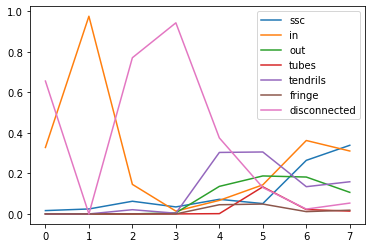

In [38]:
x = [i for i in range(len(SSC))]

plt.plot(x, ssc_lst, label="ssc")
plt.plot(x, in_lst, label="in")
plt.plot(x, out_lst , label="out")
plt.plot(x, tubes_lst, label="tubes")
plt.plot(x, tendrils_lst , label="tendrils")
plt.plot(x,fringe_lst , label="fringe")
plt.plot(x, disconnected_lst, label="disconnected")

plt.legend()
plt.plot()